In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn
from jax import config

from runner import (
    run_vsem_experiment, 
    plot_coverage,
    plot_coverage_single_rep,
)

import vsem_jax as vsem
from vsem_inv_prob import (
    InvProb, 
    VSEMPrior, 
    VSEMLikelihood,
    VSEMTest
)

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

sys.path.append("./../../helpers/")
from mcmc_uncertainty_prop import gpjaxGP, RandomKernelPCNSampler

config.update("jax_enable_x64", True)


/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/experiments/vsem/vsem_inv_prob.py:1101: SyntaxWarning: invalid escape sequence '\i'
  """
/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## VSEM Experiment 1

In [2]:
rng = np.random.default_rng(6435)
n_design = 15
n_reps = 100

tests, metrics, failed = run_vsem_experiment(rng, n_design, n_reps)

Replication 1
Optimization terminated successfully.
         Current function value: 63.149890
         Iterations: 80
         Function evaluations: 89
         Gradient evaluations: 89
Replication 2


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 77.788056
         Iterations: 100
         Function evaluations: 164
         Gradient evaluations: 153
Replication 3


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 65.363179
         Iterations: 92
         Function evaluations: 130
         Gradient evaluations: 119
Replication 4
Optimization terminated successfully.
         Current function value: 66.779048
         Iterations: 77
         Function evaluations: 82
         Gradient evaluations: 82
Replication 5


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 49.355718
         Iterations: 80
         Function evaluations: 200
         Gradient evaluations: 186
Replication 6


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 58.846974
         Iterations: 115
         Function evaluations: 209
         Gradient evaluations: 205
Replication 7


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 49.479216
         Iterations: 48
         Function evaluations: 122
         Gradient evaluations: 110
Replication 8


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 39.659918
         Iterations: 76
         Function evaluations: 109
         Gradient evaluations: 99
Replication 9


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 33.373077
         Iterations: 49
         Function evaluations: 86
         Gradient evaluations: 75
Replication 10
Optimization terminated successfully.
         Current function value: 54.022785
         Iterations: 73
         Function evaluations: 77
         Gradient evaluations: 77
Replication 11
Optimization terminated successfully.
         Current function value: 47.063641
         Iterations: 72
         Function evaluations: 88
         Gradient evaluations: 88
Replication 12
Optimization terminated successfully.
         Current function value: 67.223521
         Iterations: 59
         Function evaluations: 65
         Gradient evaluations: 65
Replication 13


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -11.869226
         Iterations: 86
         Function evaluations: 148
         Gradient evaluations: 136
Replication 14
Optimization terminated successfully.
         Current function value: 71.557251
         Iterations: 78
         Function evaluations: 87
         Gradient evaluations: 87
Replication 15


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 52.338794
         Iterations: 79
         Function evaluations: 151
         Gradient evaluations: 139
Replication 16
Optimization terminated successfully.
         Current function value: 51.657343
         Iterations: 75
         Function evaluations: 85
         Gradient evaluations: 85
Replication 17


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 50.317243
         Iterations: 70
         Function evaluations: 115
         Gradient evaluations: 104
Replication 18


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 30.607045
         Iterations: 91
         Function evaluations: 142
         Gradient evaluations: 130
Replication 19
Optimization terminated successfully.
         Current function value: 25.270737
         Iterations: 100
         Function evaluations: 146
         Gradient evaluations: 141
Replication 20
Optimization terminated successfully.
         Current function value: 47.903591
         Iterations: 112
         Function evaluations: 121
         Gradient evaluations: 121
Replication 21


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 61.095599
         Iterations: 103
         Function evaluations: 193
         Gradient evaluations: 182
Replication 22


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 45.579449
         Iterations: 93
         Function evaluations: 163
         Gradient evaluations: 153
Replication 23


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 74.419982
         Iterations: 124
         Function evaluations: 170
         Gradient evaluations: 159
Replication 24


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 50.706293
         Iterations: 94
         Function evaluations: 158
         Gradient evaluations: 146
Replication 25
Optimization terminated successfully.
         Current function value: 73.228604
         Iterations: 97
         Function evaluations: 135
         Gradient evaluations: 134
Replication 26


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 15.098971
         Iterations: 66
         Function evaluations: 162
         Gradient evaluations: 148
Replication 27
Optimization terminated successfully.
         Current function value: 82.564678
         Iterations: 79
         Function evaluations: 94
         Gradient evaluations: 94
Replication 28


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -12.601868
         Iterations: 40
         Function evaluations: 95
         Gradient evaluations: 84
Replication 29


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 63.895309
         Iterations: 81
         Function evaluations: 194
         Gradient evaluations: 179
Replication 30


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 74.033172
         Iterations: 49
         Function evaluations: 77
         Gradient evaluations: 66
Replication 31


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 60.773108
         Iterations: 68
         Function evaluations: 110
         Gradient evaluations: 100
Replication 32
Optimization terminated successfully.
         Current function value: 96.888392
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
Replication 33


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 37.871795
         Iterations: 84
         Function evaluations: 111
         Gradient evaluations: 101
Replication 34


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 38.009492
         Iterations: 100
         Function evaluations: 161
         Gradient evaluations: 151
Replication 35
Optimization terminated successfully.
         Current function value: 52.143315
         Iterations: 92
         Function evaluations: 99
         Gradient evaluations: 99
Replication 36


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 48.165172
         Iterations: 67
         Function evaluations: 155
         Gradient evaluations: 140
Replication 37


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 59.922093
         Iterations: 101
         Function evaluations: 154
         Gradient evaluations: 143
Replication 38
Optimization terminated successfully.
         Current function value: 43.134036
         Iterations: 69
         Function evaluations: 123
         Gradient evaluations: 121
Replication 39
Optimization terminated successfully.
         Current function value: 21.343315
         Iterations: 38
         Function evaluations: 52
         Gradient evaluations: 52
Replication 40


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 53.725517
         Iterations: 86
         Function evaluations: 163
         Gradient evaluations: 152
Replication 41


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 34.604870
         Iterations: 70
         Function evaluations: 127
         Gradient evaluations: 117
Replication 42


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 49.927216
         Iterations: 89
         Function evaluations: 161
         Gradient evaluations: 146
Replication 43
Optimization terminated successfully.
         Current function value: 47.508715
         Iterations: 47
         Function evaluations: 53
         Gradient evaluations: 53
Replication 44


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 77.901146
         Iterations: 117
         Function evaluations: 197
         Gradient evaluations: 185
Replication 45
Optimization terminated successfully.
         Current function value: 31.974633
         Iterations: 59
         Function evaluations: 116
         Gradient evaluations: 114
Replication 46
Optimization terminated successfully.
         Current function value: 78.267249
         Iterations: 53
         Function evaluations: 64
         Gradient evaluations: 64
Replication 47


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 65.294110
         Iterations: 95
         Function evaluations: 128
         Gradient evaluations: 118
Replication 48
Optimization terminated successfully.
         Current function value: 34.394856
         Iterations: 82
         Function evaluations: 96
         Gradient evaluations: 96
Replication 49


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 39.027374
         Iterations: 87
         Function evaluations: 181
         Gradient evaluations: 166
Replication 50


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 83.373519
         Iterations: 91
         Function evaluations: 113
         Gradient evaluations: 103
Replication 51


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 47.689125
         Iterations: 62
         Function evaluations: 109
         Gradient evaluations: 99
Replication 52
Optimization terminated successfully.
         Current function value: 61.821592
         Iterations: 103
         Function evaluations: 126
         Gradient evaluations: 126
Replication 53


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 46.269200
         Iterations: 72
         Function evaluations: 131
         Gradient evaluations: 119
Replication 54


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 69.212484
         Iterations: 96
         Function evaluations: 173
         Gradient evaluations: 162
Replication 55
Optimization terminated successfully.
         Current function value: 87.548350
         Iterations: 65
         Function evaluations: 89
         Gradient evaluations: 89
Replication 56


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 68.904894
         Iterations: 96
         Function evaluations: 140
         Gradient evaluations: 128
Replication 57


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 26.045003
         Iterations: 67
         Function evaluations: 139
         Gradient evaluations: 127
Replication 58


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 48.031376
         Iterations: 76
         Function evaluations: 115
         Gradient evaluations: 106
Replication 59
Optimization terminated successfully.
         Current function value: 23.286721
         Iterations: 58
         Function evaluations: 67
         Gradient evaluations: 67
Replication 60


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 34.886621
         Iterations: 63
         Function evaluations: 132
         Gradient evaluations: 120
Replication 61


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 26.667475
         Iterations: 118
         Function evaluations: 154
         Gradient evaluations: 141
Replication 62
Optimization terminated successfully.
         Current function value: 25.297573
         Iterations: 69
         Function evaluations: 81
         Gradient evaluations: 81
Replication 63
Optimization terminated successfully.
         Current function value: 60.091518
         Iterations: 59
         Function evaluations: 64
         Gradient evaluations: 64
Replication 64


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 53.743024
         Iterations: 54
         Function evaluations: 91
         Gradient evaluations: 80
Replication 65
Optimization terminated successfully.
         Current function value: 56.280608
         Iterations: 101
         Function evaluations: 126
         Gradient evaluations: 126
Replication 66


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 16.195851
         Iterations: 43
         Function evaluations: 108
         Gradient evaluations: 98
Replication 67
Optimization terminated successfully.
         Current function value: 54.398182
         Iterations: 74
         Function evaluations: 80
         Gradient evaluations: 80
Replication 68


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 30.472087
         Iterations: 151
         Function evaluations: 212
         Gradient evaluations: 201
Replication 69


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 66.282401
         Iterations: 93
         Function evaluations: 152
         Gradient evaluations: 140
Replication 70
Optimization terminated successfully.
         Current function value: 55.718744
         Iterations: 71
         Function evaluations: 94
         Gradient evaluations: 93
Replication 71


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 46.890778
         Iterations: 90
         Function evaluations: 183
         Gradient evaluations: 167
Replication 72
Optimization terminated successfully.
         Current function value: 68.319064
         Iterations: 100
         Function evaluations: 111
         Gradient evaluations: 111
Replication 73


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 55.037365
         Iterations: 71
         Function evaluations: 133
         Gradient evaluations: 121
Replication 74


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 26.935267
         Iterations: 68
         Function evaluations: 144
         Gradient evaluations: 131
Replication 75
Optimization terminated successfully.
         Current function value: 75.416943
         Iterations: 84
         Function evaluations: 95
         Gradient evaluations: 95
Replication 76
Optimization terminated successfully.
         Current function value: 58.698968
         Iterations: 112
         Function evaluations: 130
         Gradient evaluations: 130
Replication 77


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 14.179090
         Iterations: 49
         Function evaluations: 123
         Gradient evaluations: 111
Replication 78


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 58.450511
         Iterations: 124
         Function evaluations: 160
         Gradient evaluations: 149
Replication 79


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 60.793279
         Iterations: 98
         Function evaluations: 149
         Gradient evaluations: 137
Replication 80


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 9.870004
         Iterations: 94
         Function evaluations: 166
         Gradient evaluations: 155
Replication 81


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 41.493071
         Iterations: 75
         Function evaluations: 144
         Gradient evaluations: 133
Replication 82


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 47.183043
         Iterations: 74
         Function evaluations: 121
         Gradient evaluations: 112
Replication 83
Optimization terminated successfully.
         Current function value: 58.131658
         Iterations: 78
         Function evaluations: 93
         Gradient evaluations: 93
Replication 84


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 42.469044
         Iterations: 65
         Function evaluations: 93
         Gradient evaluations: 82
Replication 85
Optimization terminated successfully.
         Current function value: 58.848899
         Iterations: 77
         Function evaluations: 88
         Gradient evaluations: 88
Replication 86
Optimization terminated successfully.
         Current function value: 60.931173
         Iterations: 74
         Function evaluations: 90
         Gradient evaluations: 90
Replication 87


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 68.721499
         Iterations: 106
         Function evaluations: 190
         Gradient evaluations: 176
Replication 88
Optimization terminated successfully.
         Current function value: 41.822603
         Iterations: 99
         Function evaluations: 113
         Gradient evaluations: 113
Replication 89


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 49.736124
         Iterations: 42
         Function evaluations: 126
         Gradient evaluations: 115
Replication 90


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 72.608435
         Iterations: 106
         Function evaluations: 190
         Gradient evaluations: 176
Replication 91


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 48.065902
         Iterations: 76
         Function evaluations: 130
         Gradient evaluations: 118
Replication 92
Optimization terminated successfully.
         Current function value: 71.998271
         Iterations: 97
         Function evaluations: 110
         Gradient evaluations: 110
Replication 93


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 65.807223
         Iterations: 89
         Function evaluations: 145
         Gradient evaluations: 133
Replication 94


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 58.359899
         Iterations: 49
         Function evaluations: 76
         Gradient evaluations: 64
Replication 95


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -12.861441
         Iterations: 38
         Function evaluations: 112
         Gradient evaluations: 98
Replication 96
Optimization terminated successfully.
         Current function value: 43.429720
         Iterations: 75
         Function evaluations: 105
         Gradient evaluations: 104
Replication 97


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 33.823101
         Iterations: 81
         Function evaluations: 128
         Gradient evaluations: 116
Replication 98


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 31.683077
         Iterations: 69
         Function evaluations: 177
         Gradient evaluations: 164
Replication 99


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 41.072778
         Iterations: 94
         Function evaluations: 140
         Gradient evaluations: 128
Replication 100


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 47.830103
         Iterations: 91
         Function evaluations: 207
         Gradient evaluations: 193
Number of failed iterations: 0


In [3]:
# Exclude failed runs
tests = [x for i, x in enumerate(tests) if i not in failed]
metrics = [x for i, x in enumerate(metrics) if i not in failed]

print(f'Number of replicates remaining: {len(tests)}')

Number of replicates remaining: 100


In [4]:
def plot_coverage(tests: list[VSEMTest], 
                  metrics: list, 
                  q_min: float = 0.05, 
                  q_max: float = 0.95, 
                  figsize=(12, 4)):
    """
    The first two arguments are those returned by `run_vsem_experiment()`.
    Assumes the same coverage probabilities were used for all replications
    within the experiment.
    """

    # Assumed constrant across all replications
    probs = metrics[0]['alphas']

    n_reps = len(tests)
    n_probs = len(probs)
    mean_coverage = np.empty((n_reps, n_probs))
    eup_coverage = np.empty((n_reps, n_probs))
    ep_coverage = np.empty((n_reps, n_probs))

    # assemble arrays of coverage stats
    for i, results in enumerate(metrics):
        mean, eup, ep = results['coverage']
        mean_coverage[i,:] = mean
        eup_coverage[i,:] = eup
        ep_coverage[i,:] = ep

    # summarize distribution over replications
    mean_m = np.median(mean_coverage, axis=0)
    eup_m = np.median(eup_coverage, axis=0)
    ep_m = np.median(ep_coverage, axis=0)
    mean_q = np.quantile(mean_coverage, q=[q_min, q_max], axis=0)
    eup_q = np.quantile(eup_coverage, q=[q_min, q_max], axis=0)
    ep_q = np.quantile(ep_coverage, q=[q_min, q_max], axis=0)

    meds = [mean_m, eup_m, ep_m]
    qs = [mean_q, eup_q, ep_q]
    labels = ['mean', 'eup', 'ep']
    
    fig, axs = plt.subplots(1, 3, figsize=figsize)
    axs = axs.reshape(-1)
    n_plots = len(axs)

    for i in range(n_plots):
        ax = axs[i]
        q = qs[i]
        med = meds[i]
        label = labels[i]

        ax.fill_between(probs, q[0,:], q[1,:], alpha=0.4)
        ax.plot(probs, med)
        ax.set_title(label)
        ax.set_xlabel('Nominal Coverage')
        ax.set_ylabel('Actual Coverage')

        # Add line y = x
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        y = x
        ax.plot(x, y, color="red", linestyle="--")
        ax.legend()

    plt.close(fig)
    return fig, axs


/var/folders/8y/dh1rsmhx3y13wxw2h2f713qm0000gn/T/ipykernel_23534/79242264.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


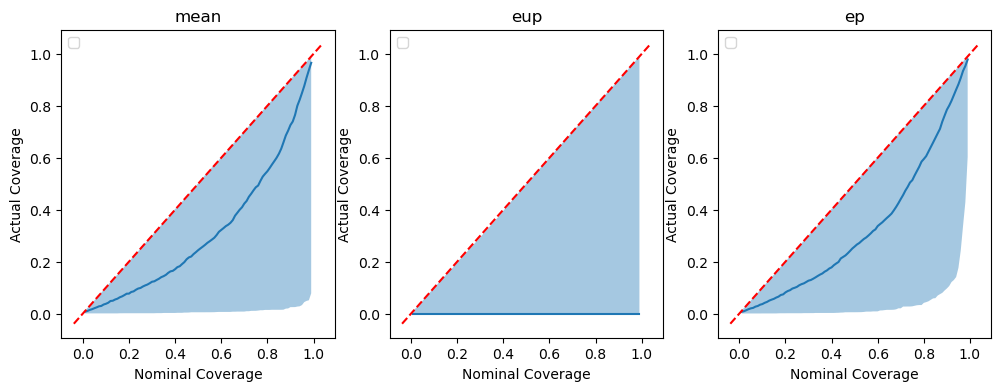

In [5]:
qmin = 0.1
qmax = 0.9

fig, ax = plot_coverage(tests, metrics, q_min=qmin, q_max=qmax)
fig.savefig(f"out/coverage1_{qmin}_{qmax}.png")
display(fig)

### Looking at one of the replicates

In [6]:
rep_idx = 0

test = tests[rep_idx]
metric = metrics[rep_idx]
inv_prob = test.inv_prob

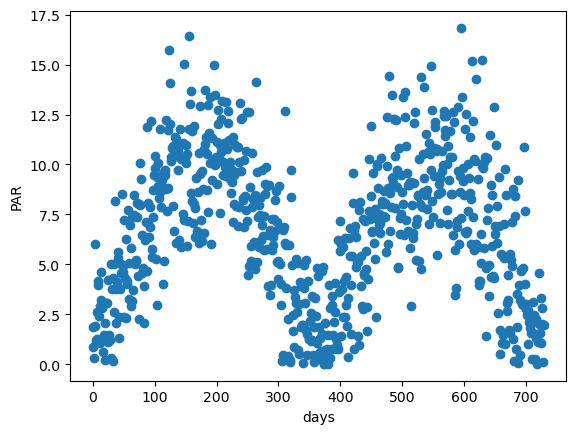

In [7]:
inv_prob.likelihood.plot_driver()
plt.close()

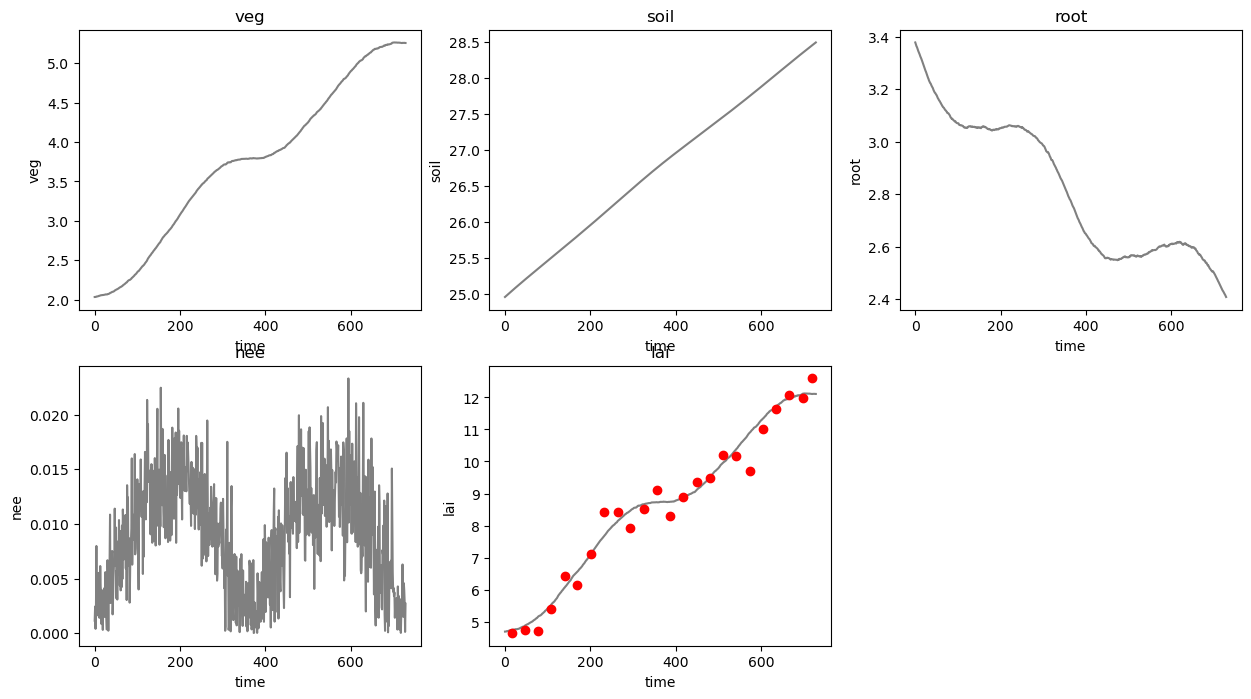

In [8]:
inv_prob.likelihood.plot_ground_truth()

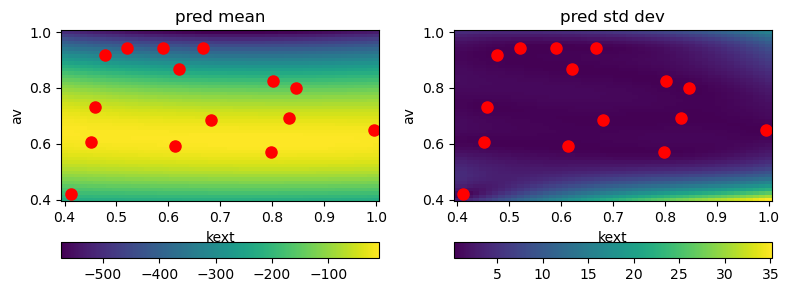

In [ ]:
# GP predictions

fig_gp, axs_gp = test.plot_gp_pred(conditional=True, pred_type='pred', markersize=8)
fig_gp.savefig(f'out/gp_pred_rep{rep_idx}.png')
display(fig_gp)
plt.close()

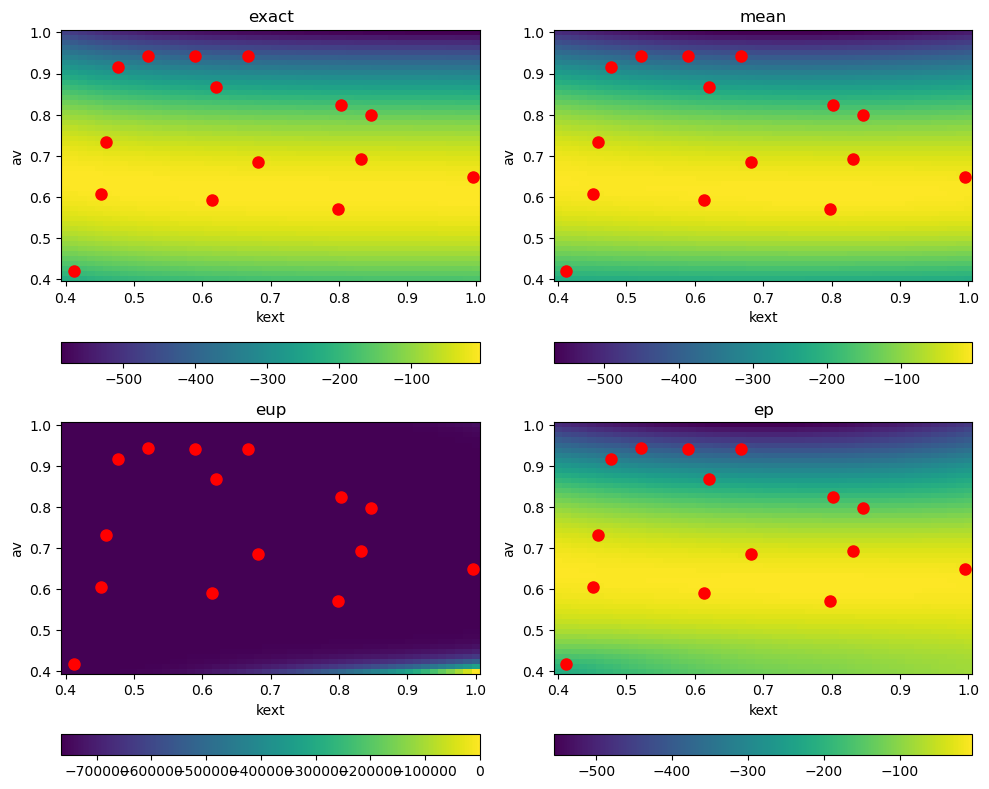

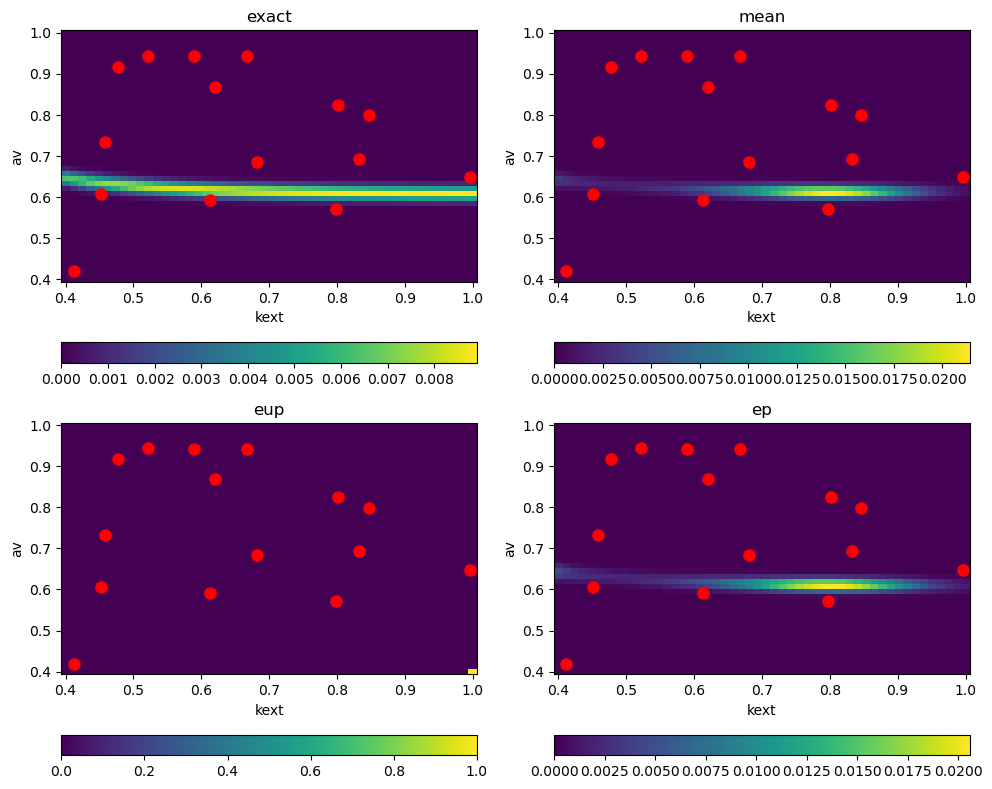

In [12]:
# Comparing posteriors
fig_log, axs_log = test.plot_posterior_comparison(shared_scale=False, log_scale=True,
                                                  pred_type='pred', nrows=2, figsize=(10,8))
fig, axs = test.plot_posterior_comparison(shared_scale=False, log_scale=False, 
                                          pred_type='pred', nrows=2, figsize=(10,8))

fig_log.savefig(f'out/post_comparison_logscale_rep{rep_idx}.png')
fig.savefig(f'out/post_comparison_rep{rep_idx}.png')
display(fig_log)
display(fig)
plt.close()

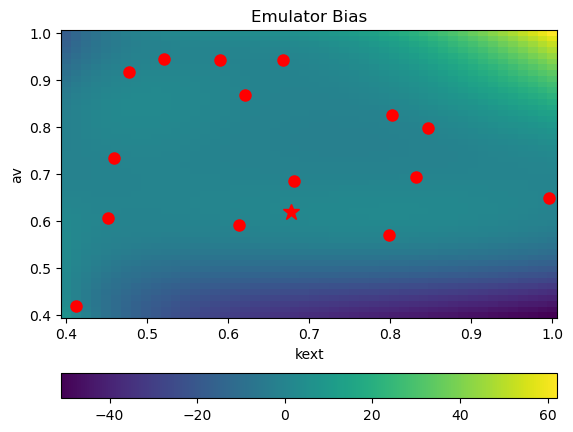

In [13]:
# Surrogate bias 

fig_bias, ax_bias = test.plot_gp_bias(conditional=True, pred_type='pred')

fig_bias.savefig(f'out/gp_bias_rep{rep_idx}.png')
display(fig_bias)
plt.close()

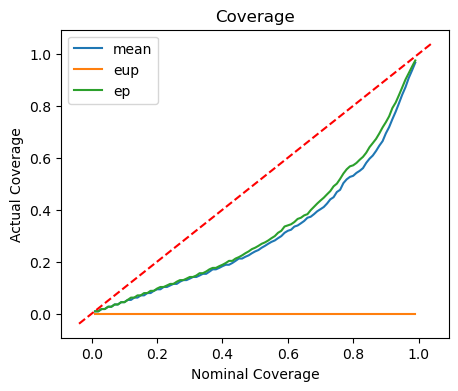

In [14]:
# Coverage plot

coverage_list = metric['coverage']
alphas = metric['alphas']

fig = plot_coverage_single_rep(alphas, coverage_list, labels=['mean', 'eup', 'ep'])
fig.savefig(f'out/coverage_rep{rep_idx}.png')
display(fig)

In [ ]:
# Sample exact posterior
inv_prob.reset_sampler()
samp, trace_plot = inv_prob.sample_posterior(n_step=20000)

display(trace_plot)
plt.close()

In [ ]:
plt.hist2d(samp[:,0], samp[:,1], bins=30, cmap='Blues')
plt.plot(*inv_prob.likelihood.par_true, "*", color="red", markersize=12)
plt.colorbar(label='Counts per bin')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Exact posterior')
plt.show()
plt.close()

In [ ]:
"""
log_dens_obs = lambda pred_obs: vsem_test.inv_prob.likelihood._likelihood_rv.log_p(pred_obs)
gpwrapped = gpjaxGP(vsem_test.gp_posterior, vsem_test.design, rng)
u_init = vsem_test.inv_prob.prior.sample()

rkpcn = RandomKernelPCNSampler(log_density=log_dens_obs,
                               gp=gpwrapped,
                               u_init=u_init,
                               u_prop_cov=proposal_cov,
                               pcn_cor=0.99,
                               rng=rng)

rkpcn.sample(num_steps=100)


n_samp = len(rkpcn.trace)
u_samp = np.empty((n_samp, prior.dim))
fu_samp = np.empty(n_samp)

for i, state in enumerate(rkpcn.trace):
    u_samp[i] = state.primary['u']
    fu_samp[i] = state.primary['fu'].squeeze()
"""